In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.options.display.float_format="{:.5f}".format
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.model_selection import GridSearchCV

from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. 데이터 로드**

### 1-1) 예매 데이터(제공)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/빅콘/final_data_membership.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793913 entries, 0 to 793912
Data columns (total 41 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연령      351443 non-null  float64
 1   성별      351653 non-null  object 
 2   예매일자    793913 non-null  int64  
 3   예매시간    793913 non-null  int64  
 4   공연일자    793913 non-null  object 
 5   공연시작시간  793913 non-null  int64  
 6   좌석      793913 non-null  object 
 7   결제가격    793913 non-null  int64  
 8   취소여부    793913 non-null  int64  
 9   할인내역    793913 non-null  object 
 10  선예매시작일  516122 non-null  float64
 11  예매시작일   793913 non-null  float64
 12  장르      793913 non-null  object 
 13  휴게시간    793913 non-null  int64  
 14  회원여부    793913 non-null  object 
 15  공연명     793913 non-null  object 
 16  내한여부    793913 non-null  int64  
 17  출연진     747065 non-null  object 
 18  제작진     76108 non-null   object 
 19  러닝타임    793913 non-null  object 
 20  관람연령    791412 non-null  object 
 21  제작사     36

In [ ]:
data.head(1)

,연령,성별,예매일자,예매시간,공연일자,공연시작시간,좌석,결제가격,취소여부,할인내역,선예매시작일,예매시작일,장르,휴게시간,회원여부,공연명,내한여부,출연진,제작진,러닝타임,관람연령,제작사,가격종류,R석,S석,A석,티켓판매량,요일,멤버십,무료,싹틔우미,노블,골드,블루,그린,층,블록,열,좌석번호,멤버십점수,멤버십등급
0,50.00000,M,20220206,1615,2022-03-02,1930,1층 B블록12열 7,180000,0,일반,20220109.00000,20220110.00000,독주,0,Y,"국립합창단 위대한 합창 Ⅰ, 칼 오르프 & 카르미나 부라나",0,"윤의중, 박미자, 박의준, 한명원 등",NaN,1시간 10분,만 7세 이상,NaN,"[30000, 20000, 10000]",30000.00000,20000.00000,10000.00000,1039,2,무료,1,0,0,0,0,0,1,B,12,7,1,D


In [ ]:
Concert = data.copy()

### 1-2) 좌석 좌표 데이터

In [ ]:
F_df = pd.read_csv('/content/drive/MyDrive/빅콘/F_df.csv')

In [ ]:
F_df

,F1,X,Y,Floor,Block,열,행,seat
0,0,-1.33619,-4.81815,1층,A블록,1열,1,1층 A블록1열 1
1,1,-1.28500,-4.83206,1층,A블록,1열,2,1층 A블록1열 2
2,2,-1.23367,-4.84542,1층,A블록,1열,3,1층 A블록1열 3
3,3,-1.18220,-4.85823,1층,A블록,1열,4,1층 A블록1열 4
4,4,-1.13059,-4.87050,1층,A블록,1열,5,1층 A블록1열 5
...,...,...,...,...,...,...,...,...
2523,633,1.68889,-0.97570,3층,BOX12,NaN,6,3층 BOX12 6
2524,634,1.68889,-0.91570,3층,BOX12,NaN,2,3층 BOX12 2
2525,635,1.72502,-0.95583,3층,BOX12,NaN,5,3층 BOX12 5
2526,636,1.72502,-0.89583,3층,BOX12,NaN,3,3층 BOX12 3


## **2. 좌석별 그룹핑**

### 2-1) 코로나 여부 -> "연도" 칼럼 생성

In [ ]:
# year 칼럼 추가
Concert['공연일자'] = Concert['공연일자'].astype(str)
Concert['연도'] = Concert['공연일자'].str[:4]

### 2-2) 멤버십 레이블링 -> "멤버십 등급" 칼럼 생성

업데이트 : 무료(1), 싹틔우미/노블(2), 그린(4), 블루(6), 골드(12)

In [ ]:
data['멤버십점수'].value_counts().sort_values(ascending=True)

25       860
21      3097
9       4005
15      5076
23     10097
11     14562
17     17967
19     32930
3      37974
7      38542
5      48496
1      67162
13     70885
0     442260
Name: 멤버십점수, dtype: int64

In [ ]:
data['멤버십등급'].value_counts().sort_values(ascending=True)

S     14054
A     50897
B     75961
D    105136
C    105605
E    442260
Name: 멤버십등급, dtype: int64

In [ ]:
# 파일로 저장
data.to_csv('membership.csv', index=False)

### 2-3) 예매/공연 거래 일자 및 시간 -> "예매와 공연 간격" 칼럼 생성

In [ ]:
Concert['예매일자'].value_counts()

20230506    6929
20230519    6270
20190812    6131
20230505    5663
20190627    5160
            ... 
20200623       1
20200821       1
20200402       1
20200507       1
20200330       1
Name: 예매일자, Length: 1601, dtype: int64

In [ ]:
Concert['공연일자'].value_counts()

2019-12-04    4923
2023-07-01    4415
2023-06-24    4360
2023-02-25    4277
2019-09-08    4168
              ... 
2021-07-17     233
2020-10-21     186
2021-12-12     127
2019-12-25      82
2021-09-14      42
Name: 공연일자, Length: 514, dtype: int64

In [ ]:
Concert['공연일자'] = pd.to_datetime(Concert['공연일자']).dt.strftime('%Y%m%d')
Concert['공연일자'].value_counts()

20191204    4923
20230701    4415
20230624    4360
20230225    4277
20190908    4168
            ... 
20210717     233
20201021     186
20211212     127
20191225      82
20210914      42
Name: 공연일자, Length: 514, dtype: int64

In [ ]:
Concert['공연일자'] = Concert['공연일자'].astype(int)
Concert['예매일자'] = Concert['예매일자'].astype(int)
Concert['예매와공연간격'] = Concert['공연일자'] - Concert['예매일자']

In [ ]:
Concert[['공연일자', '예매일자', '예매와공연간격']].head()

,공연일자,예매일자,예매와공연간격
0,20220302,20220206,96
1,20220302,20220220,82
2,20220302,20220222,80
3,20220302,20220221,81
4,20220302,20220109,193


### 2-4) 좌석 인덱스 데이터 및 파생변수 생성

In [ ]:
seat_data = Concert.groupby(['좌석','장르']).agg({'연령':['count'], # 총 예매 횟수
                                                 '결제가격':['mean'], # 평균 결제 가격
                                                 '예매와공연간격':['mean'], # 평균 예매일자 공연일자 간격
                                                 '멤버십점수':['mean']}).reset_index() # 평균 멤버십 점수

seat_data.columns = ['좌석', '장르', '총예매횟수', '평균예매가격', '평균예매와공연간격', '평균멤버십점수']

### 2-5) 좌석 인덱스 데이터, 좌석 좌표 데이터 병합

In [ ]:
seat_df= pd.merge(seat_data, F_df[['X','Y','seat']], left_on='좌석', right_on='seat', how='inner').drop('seat', axis=1)
seat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26315 entries, 0 to 26314
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   좌석         26315 non-null  object 
 1   장르         26315 non-null  object 
 2   총예매횟수      26315 non-null  int64  
 3   평균예매가격     26315 non-null  float64
 4   평균예매와공연간격  26315 non-null  float64
 5   평균멤버십점수    26315 non-null  float64
 6   X          26315 non-null  float64
 7   Y          26315 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
seat_df.head(10)

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,1층 A블록10열 1,교향곡,41,23351.14504,424.89313,2.61832,-1.46607,-5.28648
1,1층 A블록10열 1,기타,0,0.00000,60.00000,0.00000,-1.46607,-5.28648
2,1층 A블록10열 1,독주,7,38300.00000,944.00000,5.70000,-1.46607,-5.28648
3,1층 A블록10열 1,복합장르,0,22500.00000,52.25000,0.00000,-1.46607,-5.28648
4,1층 A블록10열 1,성악,1,5714.28571,97.28571,0.42857,-1.46607,-5.28648
5,1층 A블록10열 1,실내악,2,17000.00000,76.33333,2.88889,-1.46607,-5.28648
6,1층 A블록10열 1,오페라,0,0.00000,73.75000,0.00000,-1.46607,-5.28648
7,1층 A블록10열 1,콘서트,0,0.00000,37.00000,0.00000,-1.46607,-5.28648
8,1층 A블록10열 1,크로스오버,0,0.00000,95.00000,0.00000,-1.46607,-5.28648
9,1층 A블록10열 1,클래식,19,25046.15385,343.75385,2.16923,-1.46607,-5.28648


In [ ]:
seat_df.to_csv('seat_df.csv', index = False)

## 3. 클러스터링

### 3-1) 평가함수

In [ ]:
# 엘보우

def elbow(X):
    sse = []
    for k in range(1, 11):
        km = KMeans(n_clusters = k, init = 'k-means++')
        km.fit(X)
        sse.append(km.inertia_)

    sns.set(font_scale=1)
    plt.plot(range(1, 11), sse, marker ='o')
    plt.xlabel('Num of Clusters')
    plt.ylabel('SSE')
    plt.show()

In [ ]:
# 실루엣 계수

def visualize_silhouette(cluster_lists, X_features):
    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

### 3-2) 클러스터링용 데이터 생성 및 스케일링

In [ ]:
# 장르별 seat_data, 좌석과 장르 칼럼 제거
symphony = seat_data[seat_data['장르']=='교향곡'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
classic = seat_data[seat_data['장르']=='클래식'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
chorus = seat_data[seat_data['장르']=='합창'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
solo = seat_data[seat_data['장르']=='독주'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
vocal = seat_data[seat_data['장르']=='성악'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
chamber = seat_data[seat_data['장르']=='실내악'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
concert = seat_data[seat_data['장르']=='콘서트'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
opera = seat_data[seat_data['장르']=='오페라'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
mix = seat_data[seat_data['장르']=='복합장르'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
etc = seat_data[seat_data['장르']=='기타'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
jazz = seat_data[seat_data['장르']=='재즈'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)
crossover = seat_data[seat_data['장르']=='크로스오버'].drop(['좌석', '장르'], axis=1).reset_index(drop=True)

In [ ]:
symphony.head(10)

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수
0,41,23351.14504,424.89313,2.61832
1,75,31990.04975,366.63184,3.39801
2,104,40028.30189,606.91509,4.83962
3,45,19243.05556,194.54861,2.88194
4,26,16422.76423,211.01626,1.96748
5,49,21169.69697,284.35152,2.29091
6,54,32490.68323,513.92547,2.85714
7,70,19994.59459,324.29189,3.39459
8,40,21636.36364,261.65035,2.47552
9,45,22325.71429,335.90286,2.02857


In [ ]:
# 스케일링
symphony_mm = pd.DataFrame(min_max_scaler.fit_transform(symphony), columns = symphony.columns)
classic_mm = pd.DataFrame(min_max_scaler.fit_transform(classic), columns = classic.columns)
chorus_mm = pd.DataFrame(min_max_scaler.fit_transform(chorus), columns = chorus.columns)
solo_mm = pd.DataFrame(min_max_scaler.fit_transform(solo), columns = solo.columns)
vocal_mm = pd.DataFrame(min_max_scaler.fit_transform(vocal), columns = vocal.columns)
chamber_mm = pd.DataFrame(min_max_scaler.fit_transform(chamber), columns = chamber.columns)
concert_mm = pd.DataFrame(min_max_scaler.fit_transform(concert), columns = concert.columns)
opera_mm = pd.DataFrame(min_max_scaler.fit_transform(opera), columns = opera.columns)
mix_mm = pd.DataFrame(min_max_scaler.fit_transform(mix), columns = mix.columns)
etc_mm = pd.DataFrame(min_max_scaler.fit_transform(etc), columns = etc.columns)
jazz_mm = pd.DataFrame(min_max_scaler.fit_transform(jazz), columns = jazz.columns)
crossover_mm = pd.DataFrame(min_max_scaler.fit_transform(crossover), columns = crossover.columns)

### 3-3) 클러스터 생성

#### 교향곡(k=5)

##### 최적 k

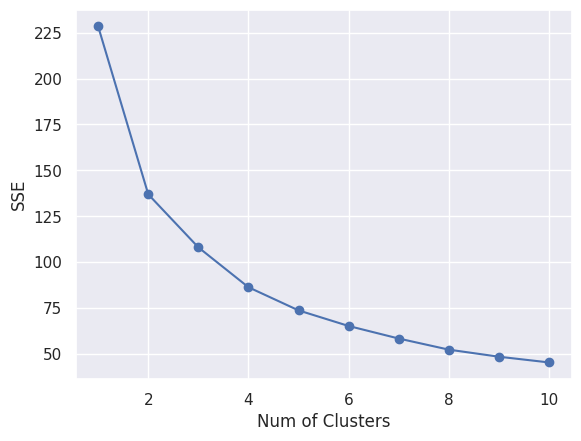

In [ ]:
elbow(symphony_mm)

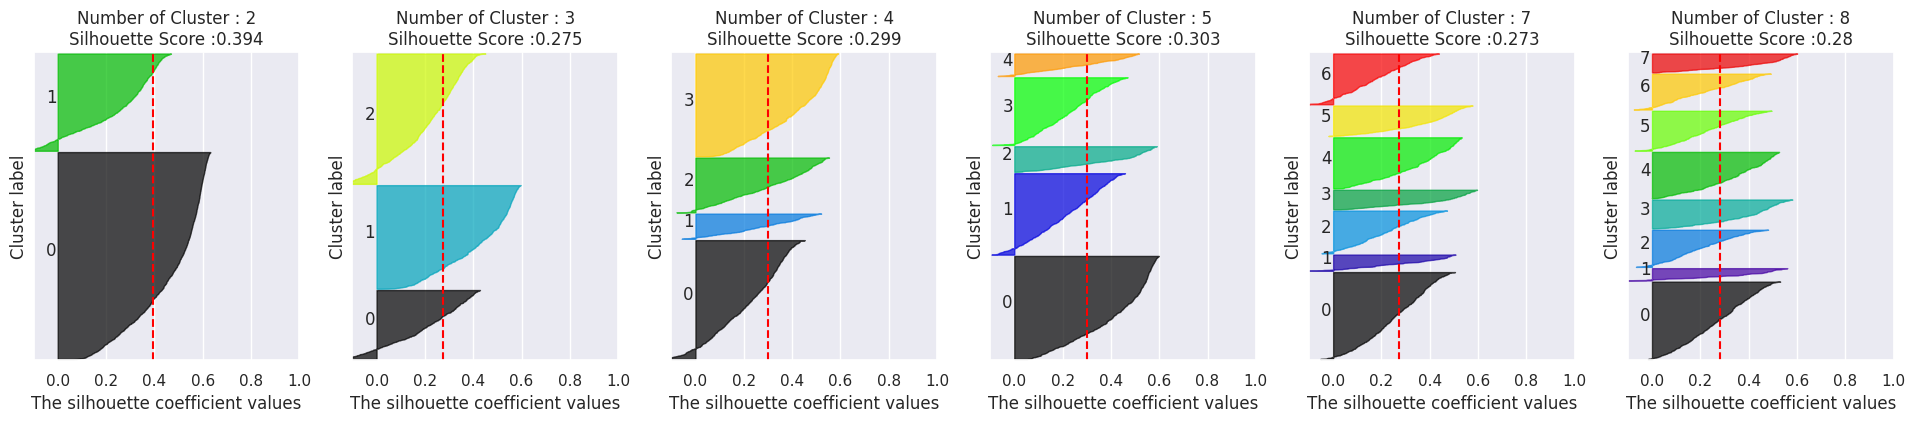

In [ ]:
visualize_silhouette([2, 3, 4, 5, 7,8], symphony_mm.values) # 2 아님 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(symphony_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = symphony_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수
0,0.36225,0.34449,0.35493,0.40222
1,0.18665,0.29262,0.15326,0.21729
2,0.46738,0.24295,0.64552,0.49729
3,0.26975,0.44056,0.15946,0.42956
4,0.61048,0.57838,0.37151,0.61766


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust['순위평균'] = sum((ranked_clust['총예매횟수'],ranked_clust['평균예매가격'],ranked_clust['평균예매와공연간격'],ranked_clust['평균멤버십점수']))/4
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,순위평균
0,3.00000,3.00000,3.00000,4.00000,3.25000
1,5.00000,4.00000,5.00000,5.00000,4.75000
2,2.00000,5.00000,1.00000,2.00000,2.50000
3,4.00000,2.00000,4.00000,3.00000,3.25000
4,1.00000,1.00000,2.00000,1.00000,1.25000


- S: 4(194개)
- A: 2(221개)
- B: 0(560개)
- C: 3(673개)
- D: 1(861개)

0, 3 평균 같음

In [ ]:
symphony_clust = seat_data[seat_data['장르']=='교향곡'].reset_index(drop=True)
symphony_clust['클러스터'] = k_means.fit_predict(symphony_mm)
symphony_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,클러스터
0,1층 A블록10열 1,교향곡,41,23351.14504,424.89313,2.61832,1
1,1층 A블록10열 10,교향곡,75,31990.04975,366.63184,3.39801,1
2,1층 A블록10열 11,교향곡,104,40028.30189,606.91509,4.83962,0
3,1층 A블록10열 2,교향곡,45,19243.05556,194.54861,2.88194,1
4,1층 A블록10열 3,교향곡,26,16422.76423,211.01626,1.96748,1


In [ ]:
symphony_clust['클러스터'].value_counts()

1    861
3    673
0    560
2    221
4    194
Name: 클러스터, dtype: int64

In [ ]:
symphony_clust.to_csv('symphony.csv', index = False)

#### 클래식(k=5)

##### 최적 k

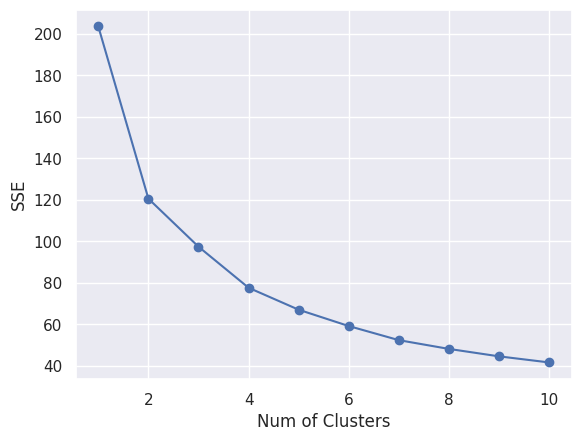

In [ ]:
elbow(classic_mm)

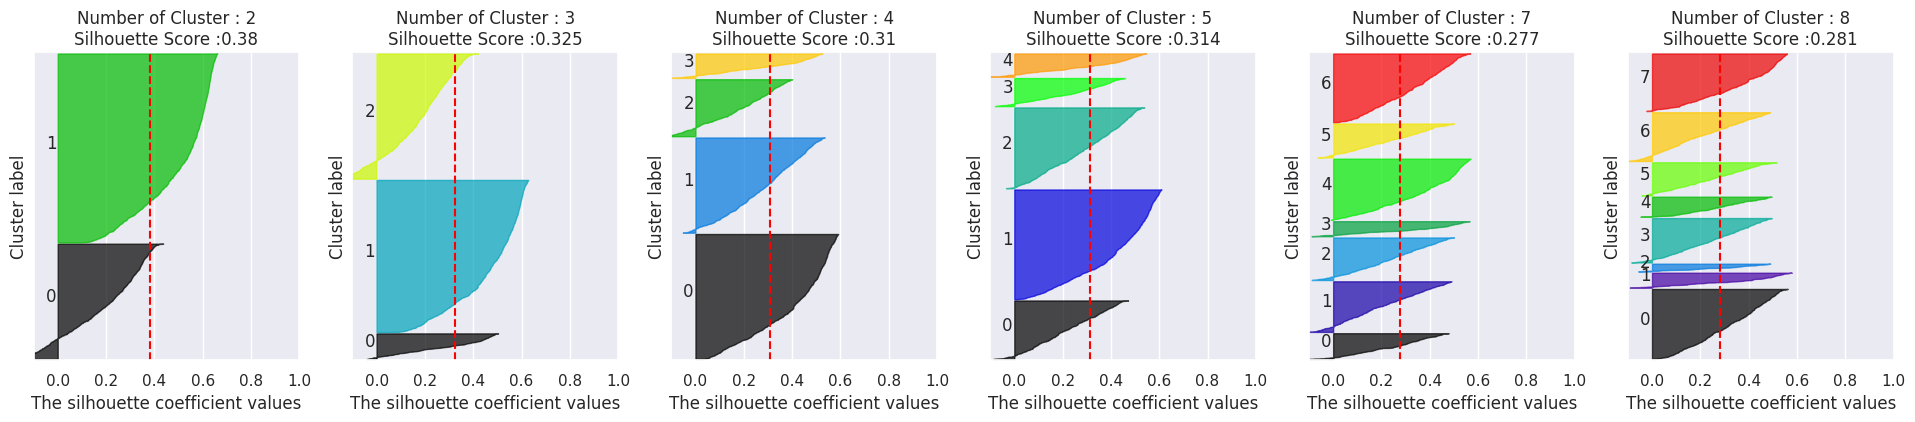

In [ ]:
visualize_silhouette([2, 3, 4, 5, 7, 8], classic_mm.values) # 2 아님 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(classic_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = classic_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수
0,0.32333,0.31757,0.30795,0.37286
1,0.15181,0.26304,0.18601,0.15278
2,0.54767,0.66491,0.25568,0.58279
3,0.27847,0.47195,0.18801,0.27422
4,0.21390,0.44283,0.45671,0.54690


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust['순위평균'] = sum((ranked_clust['총예매횟수'],ranked_clust['평균예매가격'],ranked_clust['평균예매와공연간격'],ranked_clust['평균멤버십점수']))/4
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,순위평균
0,2.00000,4.00000,2.00000,3.00000,2.75000
1,5.00000,5.00000,5.00000,5.00000,5.00000
2,1.00000,1.00000,3.00000,1.00000,1.50000
3,3.00000,2.00000,4.00000,4.00000,3.25000
4,4.00000,3.00000,1.00000,2.00000,2.50000


- S: 2(194개)
- A: 4(234개)
- B: 0(490개)
- C: 3(674개)
- D: 1(915개)

In [ ]:
classic_clust = seat_data[seat_data['장르']=='클래식'].reset_index(drop=True)
classic_clust['클러스터'] = k_means.fit_predict(classic_mm)
classic_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,클러스터
0,1층 A블록10열 1,클래식,19,25046.15385,343.75385,2.16923,1
1,1층 A블록10열 10,클래식,36,29604.16667,356.12500,2.95833,3
2,1층 A블록10열 11,클래식,31,31882.35294,405.36471,2.64706,3
3,1층 A블록10열 2,클래식,13,17266.66667,375.23333,1.71667,1
4,1층 A블록10열 3,클래식,15,16677.41935,523.09677,2.43548,1


In [ ]:
classic_clust['클러스터'].value_counts()

1    915
3    674
0    490
4    234
2    194
Name: 클러스터, dtype: int64

In [ ]:
classic_clust.to_csv('classic.csv', index = False)

##### dbscan ???

In [ ]:
eps = [0.05, 0.06, 0.07, 0.08]
for i in eps:
    db = DBSCAN(eps=i, min_samples=5)
    cluster = db.fit(classic_mm)
    cluster_id = pd.DataFrame(cluster.labels_)
    cluster_id.columns = ['cluster']

    d2 = pd.DataFrame()
    d2 = pd.concat([classic_mm, cluster_id],axis=1)

    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d2.iloc[:,:-1], d2['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d2.iloc[:,:-1], d2['cluster'])))
    print("")

Silhouette Coefficient: -0.2027
Davies Bouldin Index: 1.5680

Silhouette Coefficient: -0.1450
Davies Bouldin Index: 1.5731

Silhouette Coefficient: -0.0247
Davies Bouldin Index: 1.2819

Silhouette Coefficient: 0.0299
Davies Bouldin Index: 1.5375



In [ ]:
model = DBSCAN(min_samples = 3, eps = 0.01)
predict = pd.DataFrame(model.fit_predict(classic_mm))
predict.columns=['predict']
classic_clust['DBSCAN'] = predict
classic_clust['DBSCAN'].value_counts()

-1    2485
 0      13
 3       3
 2       3
 1       3
Name: DBSCAN, dtype: int64

#### 합창 (k=4)

##### 최적 k

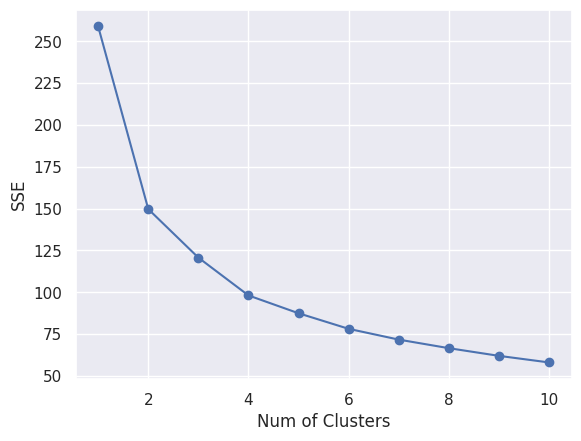

In [ ]:
elbow(chorus_mm)

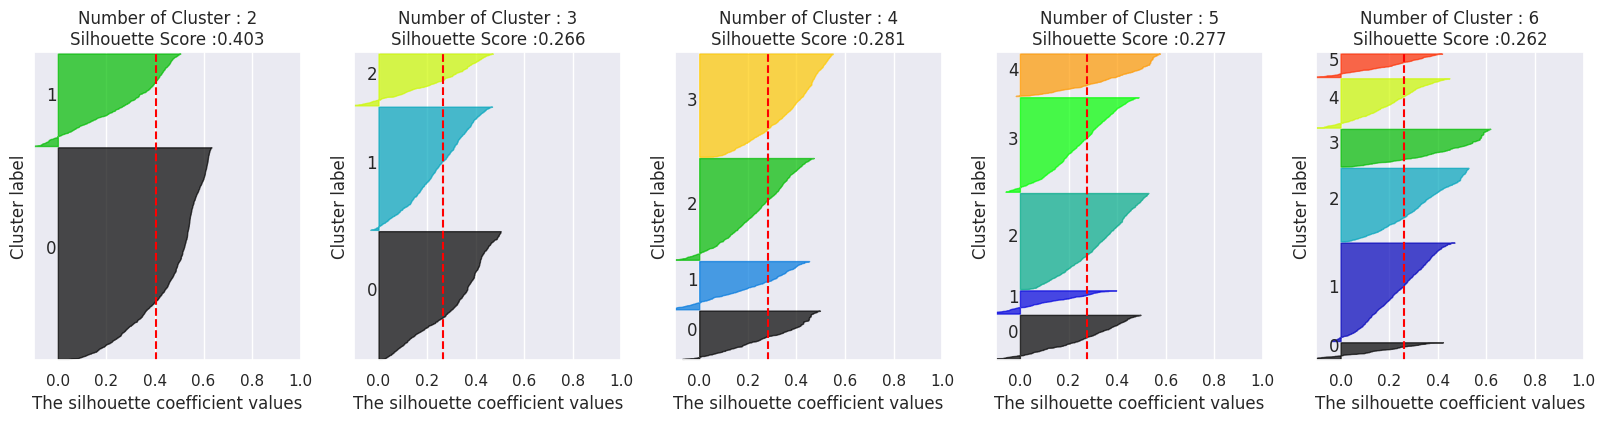

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], chorus_mm.values) # 4

##### kmeans

In [ ]:
k = 4
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(chorus_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = chorus_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수
0,0.10765,0.15119,0.14044,0.07809
1,0.26187,0.30304,0.21855,0.22772
2,0.49864,0.46890,0.22632,0.47694
3,0.08358,0.12954,0.44857,0.09999


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust['순위평균'] = sum((ranked_clust['총예매횟수'],ranked_clust['평균예매가격'],ranked_clust['평균예매와공연간격'],ranked_clust['평균멤버십점수']))/4
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,순위평균
0,3.00000,3.00000,4.00000,4.00000,3.50000
1,2.00000,2.00000,3.00000,2.00000,2.25000
2,1.00000,1.00000,2.00000,1.00000,1.25000
3,4.00000,4.00000,1.00000,3.00000,3.00000


- S: 2(396개)
- A: 1(835개)
- B: 3(410개)
- C: 0(865개)

In [ ]:
chorus_clust = seat_data[seat_data['장르']=='합창'].reset_index(drop=True)
chorus_clust['클러스터'] = k_means.fit_predict(chorus_mm)
chorus_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,클러스터
0,1층 A블록10열 1,합창,1,3550.00000,62.45000,0.65000,0
1,1층 A블록10열 10,합창,7,10483.87097,82.41935,2.03226,1
2,1층 A블록10열 11,합창,7,11187.50000,77.28125,1.59375,1
3,1층 A블록10열 2,합창,0,500.00000,62.75000,0.00000,0
4,1층 A블록10열 3,합창,3,7680.00000,57.68000,0.28000,0


In [ ]:
chorus_clust['클러스터'].value_counts()

0    865
1    835
3    410
2    396
Name: 클러스터, dtype: int64

In [ ]:
chorus_clust.to_csv('chorus.csv', index = False)

#### 독주 k(=5)

##### 최적 k

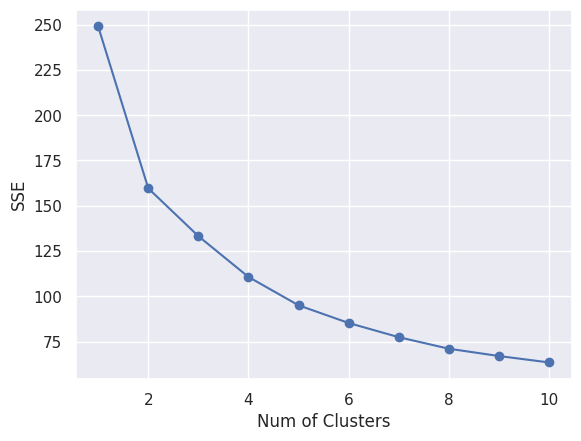

In [ ]:
elbow(solo_mm)

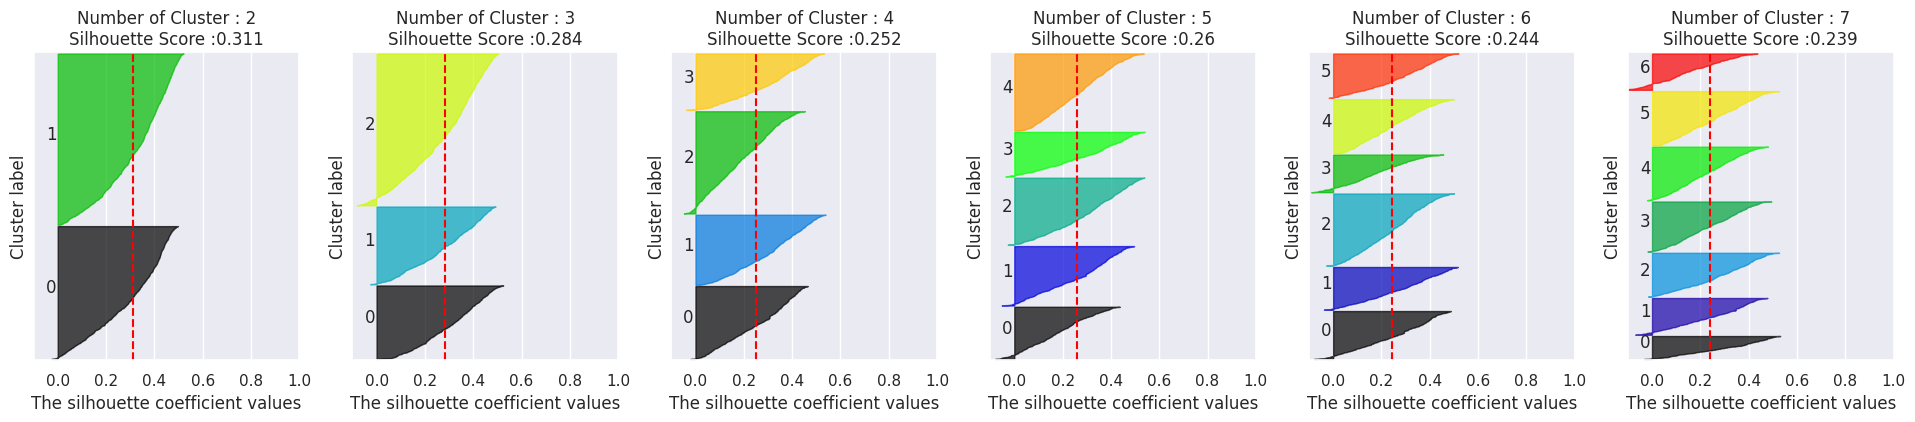

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6, 7], solo_mm.values) # 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(solo_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = chorus_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수
0,0.26735,0.68143,0.21887,0.44469
1,0.54119,0.79842,0.18645,0.64133
2,0.43423,0.47699,0.19015,0.64943
3,0.15227,0.42440,0.15771,0.29020
4,0.19362,0.50480,0.40890,0.45047


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust['순위평균'] = sum((ranked_clust['총예매횟수'],ranked_clust['평균예매가격'],ranked_clust['평균예매와공연간격'],ranked_clust['평균멤버십점수']))/4
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,순위평균
0,3.00000,2.00000,2.00000,4.00000,2.75000
1,1.00000,1.00000,4.00000,2.00000,2.00000
2,2.00000,4.00000,3.00000,1.00000,2.50000
3,5.00000,5.00000,5.00000,5.00000,5.00000
4,4.00000,3.00000,1.00000,3.00000,2.75000


- S: 1(373개)
- A: 2(557개)
- B: (0)(654개)
- B: (4)(441개)
- B: 3(478개)

0과 4의 순위 평균값이 같아서(2.75) 클러스터 보고 판단

In [ ]:
solo_clust = seat_data[seat_data['장르']=='독주'].reset_index(drop=True)
solo_clust['클러스터'] = k_means.fit_predict(solo_mm)
solo_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,클러스터
0,1층 A블록10열 1,독주,7,38300.00000,944.00000,5.70000,3
1,1층 A블록10열 10,독주,15,73952.38095,969.71429,6.23810,0
2,1층 A블록10열 11,독주,23,69966.66667,1042.20000,6.16667,0
3,1층 A블록10열 2,독주,9,55583.33333,2312.41667,4.41667,4
4,1층 A블록10열 3,독주,11,63266.66667,696.86667,5.80000,0


In [ ]:
solo_clust['클러스터'].value_counts()

0    654
2    557
3    478
4    441
1    373
Name: 클러스터, dtype: int64

In [ ]:
solo_clust.to_csv('solo.csv', index = False)

#### 성악

##### 최적 k

In [ ]:
elbow(vocal_mm)

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], vocal_mm.values) # 2 아님 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(vocal_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = vocal_mm.columns)
clust

In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

- S: 1(177개)
- A: 0(308개)
- B: 2(290개)
- C: 3(262개)
- D: 4(149개)

In [ ]:
vocal_clust = seat_data[seat_data['장르']=='성악'].reset_index(drop=True)
vocal_clust['클러스터'] = k_means.fit_predict(vocal_mm)
vocal_clust.head()

In [ ]:
vocal_clust['클러스터'].value_counts()

In [ ]:
vocal_clust.to_csv('vocal.csv', index = False)

#### 실내악

##### 최적 k

In [ ]:
elbow(chamber_mm)

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], chamber_mm.values) # 4 아님 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(chamber_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = chamber_mm.columns)
clust

In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

- S: 2(200개)
- A: 0(269개)
- B: 1(180개)
- C: 3(288개)
- D: 4(256개)

In [ ]:
chamber_clust = seat_data[seat_data['장르']=='실내악'].reset_index(drop=True)
chamber_clust['클러스터'] = k_means.fit_predict(chamber_mm)
chamber_clust.head()

In [ ]:
chamber_clust['클러스터'].value_counts()

In [ ]:
chamber_clust.to_csv('chamber.csv', index = False)

#### 콘서트

##### 최적 k

In [ ]:
elbow(concert_mm)

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], concert_mm.values) # 4 아님 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(concert_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = concert_mm.columns)
clust

In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

- S: 3(258개)
- A: 4(128개)
- B: 1(336개)
- C: 0(229개)
- D: 4(128개)

In [ ]:
concert_clust = seat_data[seat_data['장르']=='콘서트'].reset_index(drop=True)
concert_clust['클러스터'] = k_means.fit_predict(concert_mm)
concert_clust.head()

In [ ]:
concert_clust['클러스터'].value_counts()

In [ ]:
concert_clust.to_csv('concert.csv', index = False)

#### 오페라

##### 최적 k

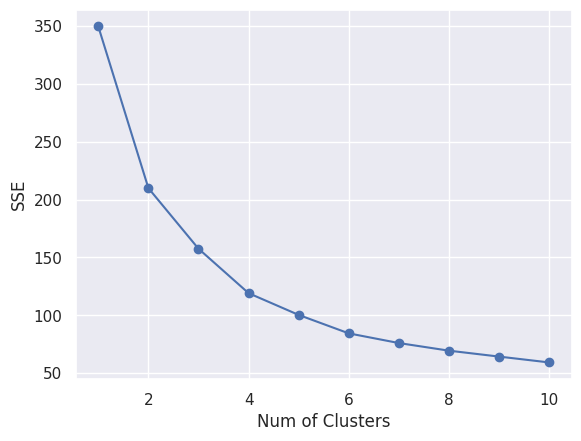

In [ ]:
elbow(opera_mm)

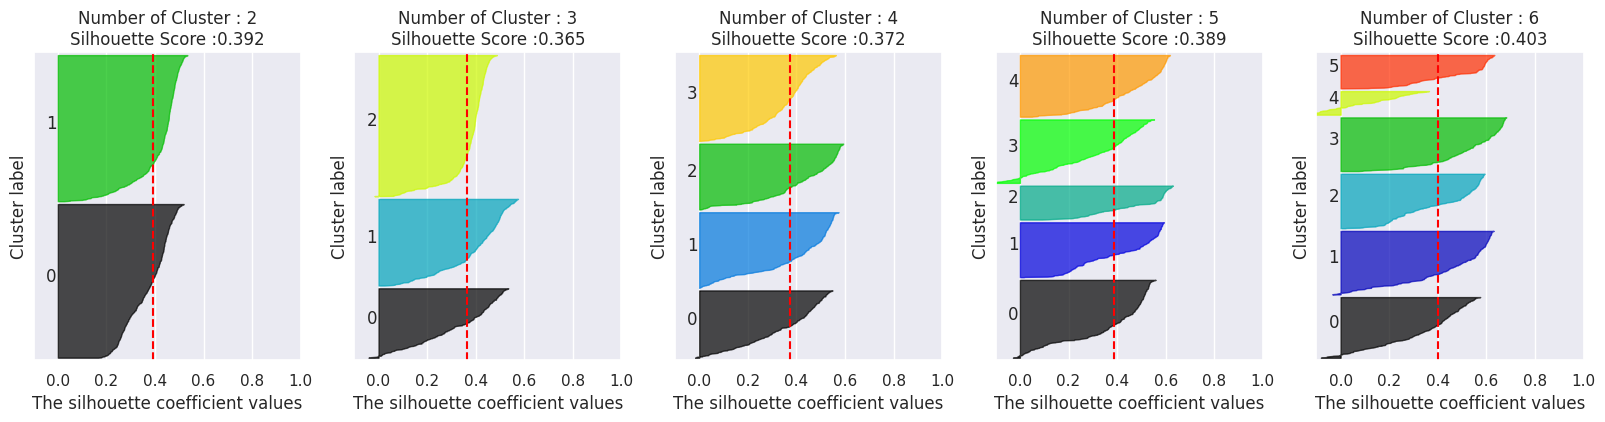

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], opera_mm.values) # 4 아님 5

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(opera_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = opera_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.08100,0.07159,0.40509,0.10009,0.19124,0.76213
1,0.07445,0.08448,0.50846,0.10245,0.71520,0.09985
2,0.09161,0.09451,0.40516,0.13173,0.72027,0.73842
3,0.07464,0.10365,0.47078,0.11363,0.23534,0.12387
4,0.33913,0.41942,0.65250,0.49704,0.45666,0.12412


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,3.00000,5.00000,5.00000,5.00000,5.00000,1.00000
1,5.00000,4.00000,2.00000,4.00000,2.00000,5.00000
2,2.00000,3.00000,4.00000,2.00000,1.00000,2.00000
3,4.00000,2.00000,3.00000,3.00000,4.00000,4.00000
4,1.00000,1.00000,1.00000,1.00000,3.00000,3.00000


- S: 4(252개)
- A: 2(309개)
- B: 3(135개)
- C: 1(218개)
- D: 0(245개)

In [ ]:
opera_clust = seat_data[seat_data['장르']=='오페라'].reset_index(drop=True)
opera_clust['클러스터'] = k_means.fit_predict(opera_mm)
opera_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,오페라,1,3000.00000,69.14286,1.85714,-1.03268,-5.38793,3
1,1층 A블록10열 11,오페라,2,15142.85714,82.85714,2.85714,-1.06386,-5.43689,3
2,1층 A블록10열 4,오페라,0,0.00000,67.33333,0.00000,-0.93426,-5.07675,3
3,1층 A블록10열 5,오페라,0,0.00000,77.60000,0.00000,-0.94403,-5.12986,3
4,1층 A블록10열 6,오페라,1,2142.85714,69.85714,3.00000,-0.97753,-5.17855,3


In [ ]:
opera_clust['클러스터'].value_counts()

2    309
4    252
0    245
1    218
3    135
Name: 클러스터, dtype: int64

In [ ]:
opera_clust.to_csv('opera.csv', index = False)

#### k=6

##### kmeans

In [ ]:
k = 6
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(opera_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = opera_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.07445,0.08448,0.50846,0.10245,0.71520,0.09985
1,0.06027,0.05487,0.39530,0.07219,0.74148,0.73578
2,0.05581,0.04527,0.39495,0.04924,0.19541,0.75467
3,0.07405,0.10300,0.46885,0.11219,0.23437,0.12437
4,0.33650,0.41646,0.65710,0.48593,0.46164,0.09756
5,0.25992,0.29219,0.46951,0.46085,0.44561,0.77243


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,3.00000,4.00000,2.00000,4.00000,2.00000,5.00000
1,5.00000,5.00000,5.00000,5.00000,1.00000,3.00000
2,6.00000,6.00000,6.00000,6.00000,6.00000,2.00000
3,4.00000,3.00000,4.00000,3.00000,5.00000,4.00000
4,1.00000,1.00000,1.00000,1.00000,3.00000,6.00000
5,2.00000,2.00000,3.00000,2.00000,4.00000,1.00000


- S: 4(243개)
- A: 5(95개)
- B: 0(218개)
- C: 3(134개)
- D: 1(254개)
- E: 2(215개)

In [ ]:
opera_clust = seat_data[seat_data['장르']=='오페라'].reset_index(drop=True)
opera_clust['클러스터'] = k_means.fit_predict(opera_mm)
opera_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,오페라,1,3000.00000,69.14286,1.85714,-1.03268,-5.38793,3
1,1층 A블록10열 11,오페라,2,15142.85714,82.85714,2.85714,-1.06386,-5.43689,3
2,1층 A블록10열 4,오페라,0,0.00000,67.33333,0.00000,-0.93426,-5.07675,3
3,1층 A블록10열 5,오페라,0,0.00000,77.60000,0.00000,-0.94403,-5.12986,3
4,1층 A블록10열 6,오페라,1,2142.85714,69.85714,3.00000,-0.97753,-5.17855,3


In [ ]:
opera_clust['클러스터'].value_counts()

1    254
4    243
0    218
2    215
3    134
5     95
Name: 클러스터, dtype: int64

In [ ]:
opera_clust.to_csv('opera6.csv', index = False)

#### 복합장르

##### 최적 k

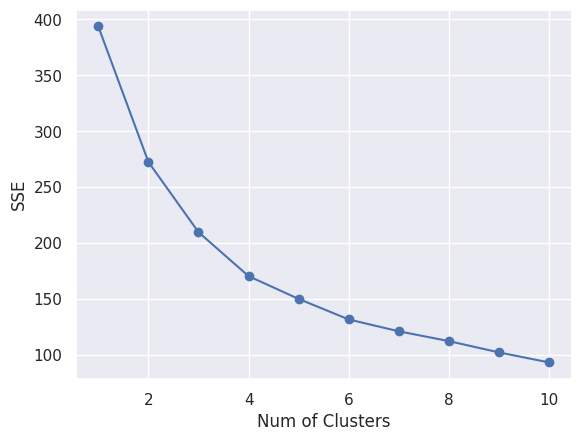

In [ ]:
elbow(mix_mm)

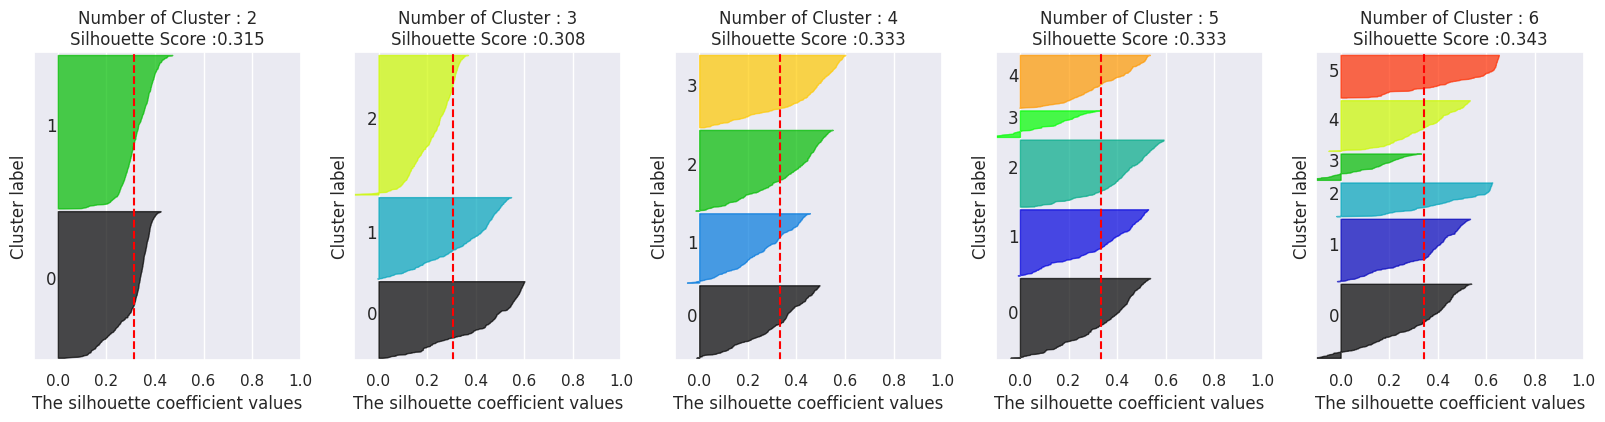

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6], mix_mm.values) # 5 아님 6

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(mix_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = mix_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.03996,0.09247,0.01393,0.04856,0.54632,0.11741
1,0.10236,0.23680,0.03773,0.09851,0.72794,0.70338
2,0.30220,0.50041,0.05814,0.46143,0.47421,0.09649
3,0.33778,0.42995,0.11133,0.56588,0.45465,0.80692
4,0.09638,0.26937,0.03244,0.07821,0.20781,0.72481


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,5.00000,5.00000,5.00000,5.00000,2.00000,4.00000
1,3.00000,4.00000,3.00000,3.00000,1.00000,3.00000
2,2.00000,1.00000,2.00000,2.00000,3.00000,5.00000
3,1.00000,2.00000,1.00000,1.00000,4.00000,1.00000
4,4.00000,3.00000,4.00000,4.00000,5.00000,2.00000


- S: 3(109개)
- A: 2(326개)
- B: 1(270개)
- C: 4(216개)
- D: 0(274개)

In [ ]:
mix_clust = seat_data[seat_data['장르']=='복합장르'].reset_index(drop=True)
mix_clust['클러스터'] = k_means.fit_predict(mix_mm)
mix_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,복합장르,2,22500.00000,2304.25000,7.00000,-1.03268,-5.38793,2
1,1층 A블록10열 11,복합장르,2,36750.00000,2274.50000,8.50000,-1.06386,-5.43689,2
2,1층 A블록10열 4,복합장르,2,32400.00000,62.80000,1.20000,-0.93426,-5.07675,0
3,1층 A블록10열 5,복합장르,0,0.00000,30.66667,0.00000,-0.94403,-5.12986,0
4,1층 A블록10열 6,복합장르,0,0.00000,43.50000,0.00000,-0.97753,-5.17855,0


In [ ]:
mix_clust['클러스터'].value_counts()

2    326
0    274
1    270
4    216
3    109
Name: 클러스터, dtype: int64

In [ ]:
mix_clust.to_csv('mix.csv', index = False)

##### k=6

In [ ]:
k = 6
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(mix_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = mix_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.04935,0.10212,0.01551,0.08648,0.25555,0.14629
1,0.31152,0.51384,0.06098,0.46944,0.47996,0.09470
2,0.33778,0.42995,0.11133,0.56588,0.45465,0.80692
3,0.04677,0.11971,0.01336,0.05579,0.76263,0.12590
4,0.10091,0.28846,0.03296,0.08201,0.20979,0.73785
5,0.10294,0.22549,0.03858,0.09579,0.72660,0.71802


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,5.00000,6.00000,5.00000,4.00000,5.00000,4.00000
1,2.00000,1.00000,2.00000,2.00000,3.00000,6.00000
2,1.00000,2.00000,1.00000,1.00000,4.00000,1.00000
3,6.00000,5.00000,6.00000,6.00000,1.00000,5.00000
4,4.00000,3.00000,4.00000,5.00000,6.00000,2.00000
5,3.00000,4.00000,3.00000,3.00000,2.00000,3.00000


- S: 2(109개)
- A: 1(307개)
- B: 5(257개)
- C: 4(209개)
- D: 0(140개)
- E: 3(173개)

0 5
1 1.75
2 1.25
3 5.75
4 4
5 3.25

In [ ]:
mix_clust = seat_data[seat_data['장르']=='복합장르'].reset_index(drop=True)
mix_clust['클러스터'] = k_means.fit_predict(mix_mm)
mix_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,복합장르,2,22500.00000,2304.25000,7.00000,-1.03268,-5.38793,1
1,1층 A블록10열 11,복합장르,2,36750.00000,2274.50000,8.50000,-1.06386,-5.43689,1
2,1층 A블록10열 4,복합장르,2,32400.00000,62.80000,1.20000,-0.93426,-5.07675,0
3,1층 A블록10열 5,복합장르,0,0.00000,30.66667,0.00000,-0.94403,-5.12986,0
4,1층 A블록10열 6,복합장르,0,0.00000,43.50000,0.00000,-0.97753,-5.17855,0


In [ ]:
mix_clust['클러스터'].value_counts()

1    307
5    257
4    209
3    173
0    140
2    109
Name: 클러스터, dtype: int64

In [ ]:
mix_clust.to_csv('mix6.csv', index = False)

#### 기타

##### 최적 k

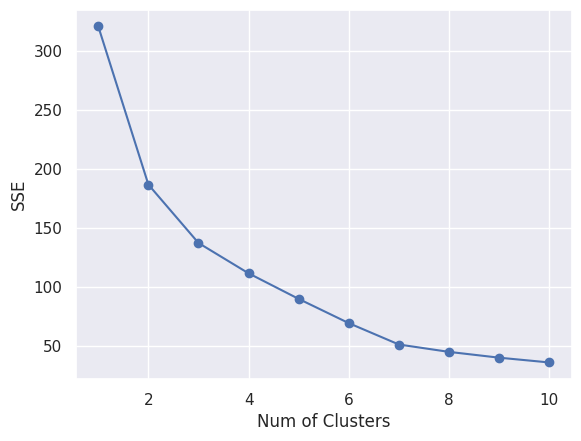

In [ ]:
elbow(etc_mm)

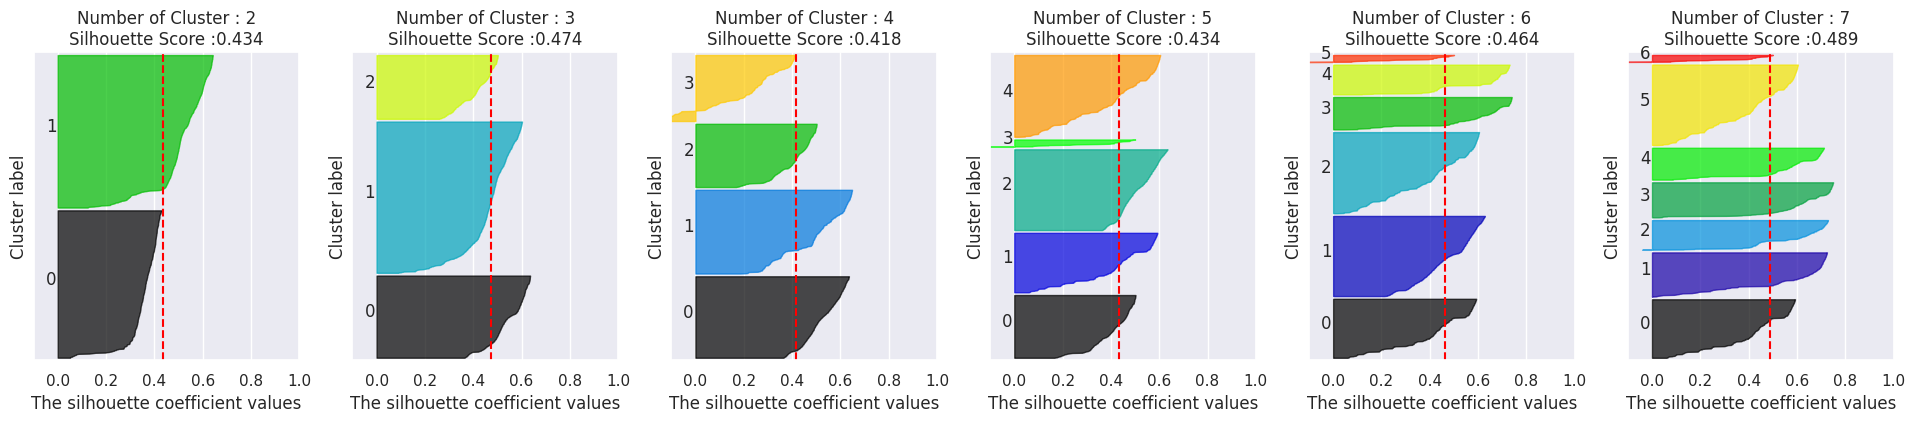

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6, 7], etc_mm.values) # 3 아님 6 아님 7

##### kmeans

In [ ]:
k = 6
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(etc_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = etc_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.60345,0.59898,0.66461,0.47492,0.38640,0.09253
1,-0.00000,-0.00000,0.64296,0.00000,0.46997,0.74946
2,-0.00000,0.00184,0.05329,0.00000,0.80980,0.70180
3,0.00153,0.02202,0.64860,0.00019,0.67109,0.10056
4,-0.00000,0.03925,0.59980,0.00000,0.28811,0.10984
5,-0.00000,-0.00000,0.05419,0.00000,0.22182,0.71569


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,1.00000,1.00000,1.00000,1.00000,4.00000,6.00000
1,3.00000,6.00000,3.00000,4.00000,3.00000,1.00000
2,5.00000,4.00000,6.00000,6.00000,1.00000,3.00000
3,2.00000,3.00000,2.00000,2.00000,2.00000,5.00000
4,5.00000,2.00000,4.00000,3.00000,5.00000,4.00000
5,5.00000,5.00000,5.00000,5.00000,6.00000,2.00000


- S: 0(29개)
- A: 3(327개)
- B: 4(238개)
- C: 1(323개)
- D: 5(130개)
- E: 2(121개)

0 1
1 4
2 5.25
3 2.75
4 3.5
5 5

In [ ]:
etc_clust = seat_data[seat_data['장르']=='기타'].reset_index(drop=True)
etc_clust['클러스터'] = k_means.fit_predict(etc_mm)
etc_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,기타,0,0.00000,60.00000,0.00000,-1.03268,-5.38793,4
1,1층 A블록10열 11,기타,0,0.00000,60.00000,0.00000,-1.06386,-5.43689,4
2,1층 A블록10열 4,기타,0,0.00000,60.00000,0.00000,-0.93426,-5.07675,4
3,1층 A블록10열 5,기타,0,0.00000,60.00000,0.00000,-0.94403,-5.12986,4
4,1층 A블록10열 6,기타,0,0.00000,60.00000,0.00000,-0.97753,-5.17855,4


In [ ]:
etc_clust['클러스터'].value_counts()

3    327
1    323
4    238
5    130
2    121
0     29
Name: 클러스터, dtype: int64

In [ ]:
etc_clust.to_csv('etc.csv', index = False)

##### k=3

In [ ]:
k = 3
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(etc_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = etc_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,-0.00000,0.00089,0.05376,0.00000,0.50527,0.70899
1,0.03030,0.05709,0.62983,0.02329,0.50374,0.10388
2,-0.00000,-0.00000,0.64296,0.00000,0.46997,0.74946


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,3.00000,2.00000,3.00000,2.00000,1.00000,2.00000
1,1.00000,1.00000,2.00000,1.00000,2.00000,3.00000
2,2.00000,3.00000,1.00000,3.00000,3.00000,1.00000


- S: 1(594개)
- A: 2(323개)
- B: 0(251개)

0 2.5
1 1.24
2 2.25

In [ ]:
etc_clust = seat_data[seat_data['장르']=='기타'].reset_index(drop=True)
etc_clust['클러스터'] = k_means.fit_predict(etc_mm)
etc_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,기타,0,0.00000,60.00000,0.00000,-1.03268,-5.38793,1
1,1층 A블록10열 11,기타,0,0.00000,60.00000,0.00000,-1.06386,-5.43689,1
2,1층 A블록10열 4,기타,0,0.00000,60.00000,0.00000,-0.93426,-5.07675,1
3,1층 A블록10열 5,기타,0,0.00000,60.00000,0.00000,-0.94403,-5.12986,1
4,1층 A블록10열 6,기타,0,0.00000,60.00000,0.00000,-0.97753,-5.17855,1


In [ ]:
etc_clust['클러스터'].value_counts()

1    594
2    323
0    251
Name: 클러스터, dtype: int64

In [ ]:
etc_clust.to_csv('etc3.csv', index = False)

#### 재즈

##### 최적 k

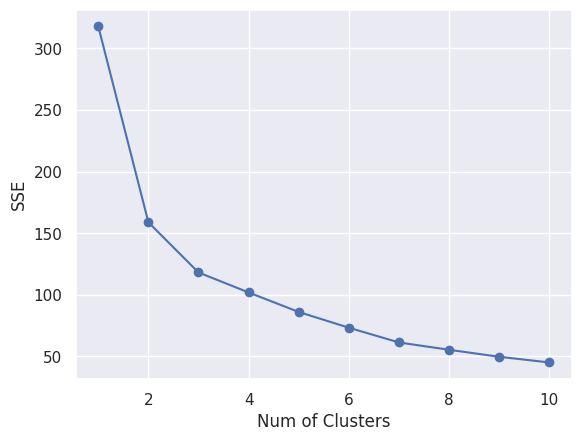

In [ ]:
elbow(jazz_mm)

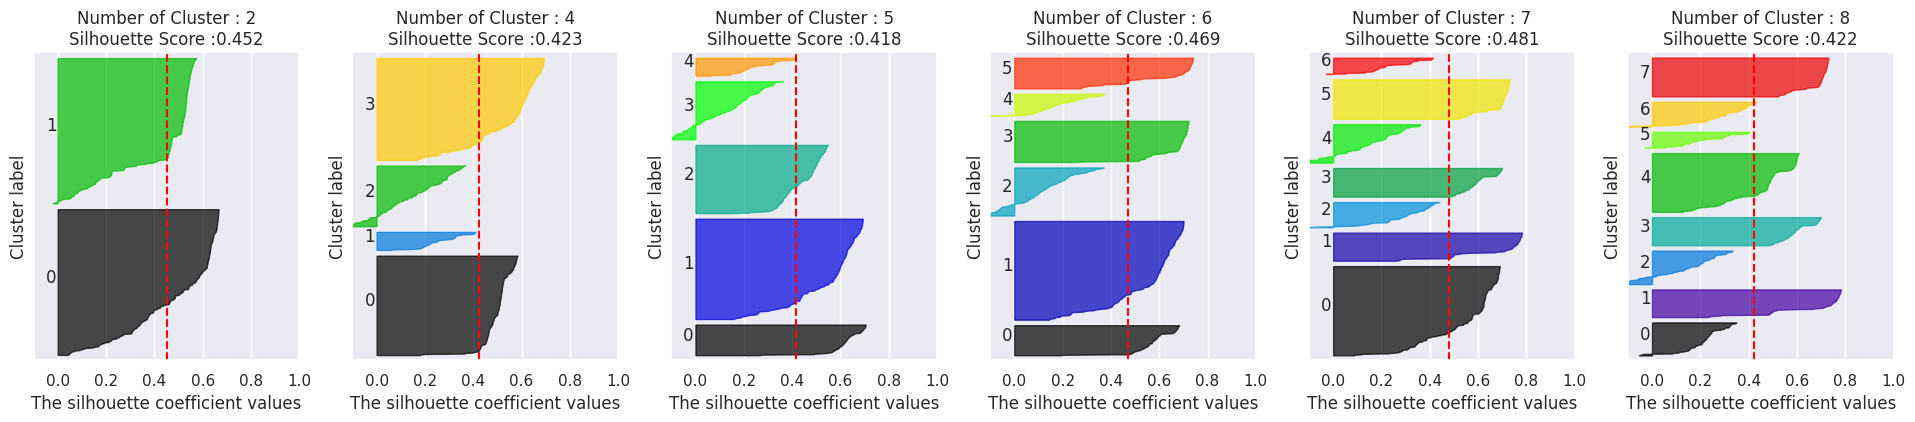

In [ ]:
visualize_silhouette([2, 4, 5, 6, 7, 8], jazz_mm.values) # 6 아님 7

##### kmeans

In [ ]:
k = 6
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(jazz_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = jazz_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.28940,0.83679,0.95600,0.48587,0.47006,0.07312
1,0.00000,0.00840,0.10809,0.00000,0.46631,0.09820
2,0.20833,0.80506,0.07237,0.20667,0.40010,0.70459
3,0.32955,0.61449,0.74606,0.43833,0.61059,0.80102
4,-0.00000,0.00000,0.03105,0.00000,0.56412,0.70045
5,0.29573,0.74210,0.28914,0.18699,0.57248,0.09852


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,3.00000,1.00000,1.00000,1.00000,4.00000,6.00000
1,5.00000,5.00000,4.00000,5.00000,5.00000,5.00000
2,4.00000,2.00000,5.00000,3.00000,6.00000,2.00000
3,1.00000,4.00000,2.00000,2.00000,1.00000,1.00000
4,6.00000,6.00000,6.00000,6.00000,3.00000,3.00000
5,2.00000,3.00000,3.00000,4.00000,2.00000,4.00000


- S: 0(29개)
- A: 3(327개)
- B: 4(238개)
- C: 1(323개)
- D: 5(130개)
- E: 2(121개)

0 1
1 4
2 5.25
3 2.75
4 3.5
5 5

In [ ]:
jazz_clust = seat_data[seat_data['장르']=='재즈'].reset_index(drop=True)
jazz_clust['클러스터'] = k_means.fit_predict(jazz_mm)
jazz_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,재즈,2,35000.00000,101.00000,1.00000,-1.03268,-5.38793,5
1,1층 A블록10열 11,재즈,1,35000.00000,101.00000,1.00000,-1.06386,-5.43689,5
2,1층 A블록10열 6,재즈,0,0.00000,91.00000,0.00000,-0.97753,-5.17855,1
3,1층 A블록10열 7,재즈,0,0.00000,91.00000,0.00000,-0.98754,-5.23161,1
4,1층 A블록10열 8,재즈,0,0.00000,91.00000,0.00000,-1.01235,-5.28186,1


In [ ]:
jazz_clust['클러스터'].value_counts()

0    184
1    134
5     82
4     59
3     44
2     42
Name: 클러스터, dtype: int64

In [ ]:
jazz_clust.to_csv('jazz.csv', index = False)

#### 크로스오버

##### 최적 k

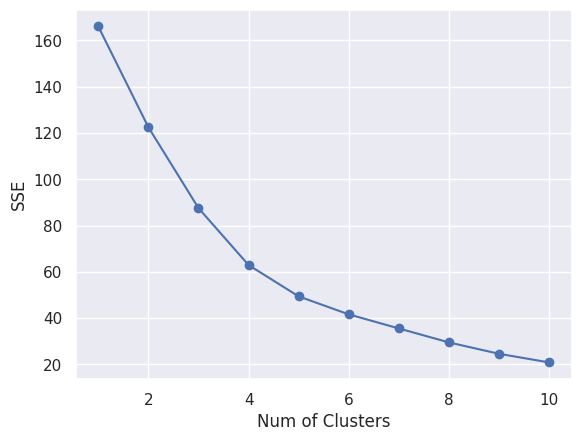

In [ ]:
elbow(crossover_mm)

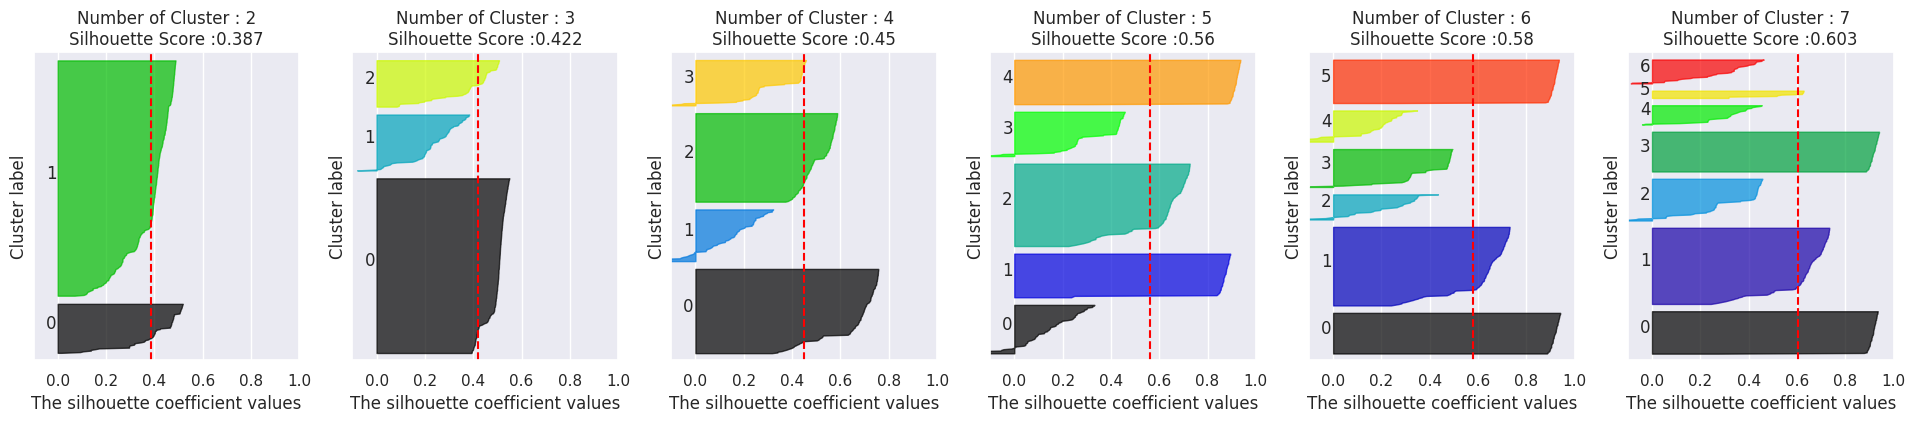

In [ ]:
visualize_silhouette([2, 3, 4, 5, 6, 7], crossover_mm.values) # 5 아님 6 아님 7 별로 적합?하다고 할 만한 게 없는,,

##### kmeans

In [ ]:
k = 5
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(crossover_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = crossover_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.40376,0.54903,0.91838,0.31154,0.45065,0.66423
1,0.01111,0.00694,0.86754,0.00198,0.35399,0.70574
2,0.01562,0.02344,0.86957,0.01451,0.19843,0.09031
3,0.06667,0.17094,0.05355,0.06410,0.60545,0.74930
4,-0.00000,-0.00000,0.86652,-0.00000,0.85476,0.09515


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,1.00000,1.00000,1.00000,1.00000,3.00000,3.00000
1,4.00000,4.00000,3.00000,4.00000,4.00000,2.00000
2,3.00000,3.00000,2.00000,3.00000,5.00000,5.00000
3,2.00000,2.00000,5.00000,2.00000,2.00000,1.00000
4,5.00000,5.00000,4.00000,5.00000,1.00000,4.00000


- S: 0(29개)
- A: 3(327개)
- B: 2(238개)
- C: 1(323개)
- D: 4(130개)

0 1
1 3.75
2 2.75
3 2.75
4 4.75

In [ ]:
crossover_clust = seat_data[seat_data['장르']=='크로스오버'].reset_index(drop=True)
crossover_clust['클러스터'] = k_means.fit_predict(crossover_mm)
crossover_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,크로스오버,0,0.00000,95.00000,0.00000,-1.03268,-5.38793,2
1,1층 A블록10열 11,크로스오버,0,0.00000,95.00000,0.00000,-1.06386,-5.43689,2
2,1층 A블록10열 4,크로스오버,0,0.00000,95.00000,0.00000,-0.93426,-5.07675,2
3,1층 A블록10열 5,크로스오버,0,0.00000,95.00000,0.00000,-0.94403,-5.12986,2
4,1층 A블록10열 6,크로스오버,0,0.00000,95.00000,0.00000,-0.97753,-5.17855,2


In [ ]:
crossover_clust['클러스터'].value_counts()

1    120
0     71
4     65
3     65
2     64
Name: 클러스터, dtype: int64

In [ ]:
crossover_clust.to_csv('crossover.csv', index = False)

##### k=6

In [ ]:
k = 6
k_means = KMeans(n_clusters = k, max_iter=300, random_state=42)
k_means.fit(crossover_mm)

# 클러스터별 센터값
clust = k_means.cluster_centers_
clust = pd.DataFrame(clust, columns = crossover_mm.columns)
clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,0.00285,0.00102,0.86736,0.00102,0.35936,0.70378
1,0.41135,0.54177,0.91246,0.26900,0.18905,0.56430
2,0.36842,0.50801,0.78045,0.36529,0.80131,0.76568
3,0.02924,0.13228,0.02723,0.01420,0.57898,0.74961
4,-0.00000,-0.00000,0.86652,-0.00000,0.85476,0.09515
5,-0.00000,-0.00000,0.86667,-0.00000,0.19913,0.09253


In [ ]:
ranked_clust = clust.rank(ascending = False)
ranked_clust

,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y
0,4.00000,4.00000,2.00000,4.00000,4.00000,3.00000
1,1.00000,1.00000,1.00000,2.00000,6.00000,4.00000
2,2.00000,2.00000,5.00000,1.00000,2.00000,1.00000
3,3.00000,3.00000,6.00000,3.00000,3.00000,2.00000
4,6.00000,5.50000,4.00000,5.00000,1.00000,5.00000
5,5.00000,5.50000,3.00000,6.00000,5.00000,6.00000


- S: 1(47개)
- A: 2(38개)
- B: 0(117개)
- C: 3(57개)
- D: 4(65개)
- E: 5(61개)

0 3.5
1 1.25
2 2.5
3 3.75
4 5.125
5 4.875

In [ ]:
crossover_clust = seat_data[seat_data['장르']=='크로스오버'].reset_index(drop=True)
crossover_clust['클러스터'] = k_means.fit_predict(crossover_mm)
crossover_clust.head()

,좌석,장르,총예매횟수,평균예매가격,평균예매와공연간격,평균멤버십점수,X,Y,클러스터
0,1층 A블록10열 10,크로스오버,0,0.00000,95.00000,0.00000,-1.03268,-5.38793,5
1,1층 A블록10열 11,크로스오버,0,0.00000,95.00000,0.00000,-1.06386,-5.43689,5
2,1층 A블록10열 4,크로스오버,0,0.00000,95.00000,0.00000,-0.93426,-5.07675,5
3,1층 A블록10열 5,크로스오버,0,0.00000,95.00000,0.00000,-0.94403,-5.12986,5
4,1층 A블록10열 6,크로스오버,0,0.00000,95.00000,0.00000,-0.97753,-5.17855,5


In [ ]:
crossover_clust['클러스터'].value_counts()

0    117
4     65
5     61
3     57
1     47
2     38
Name: 클러스터, dtype: int64

In [ ]:
crossover_clust.to_csv('crossover6.csv', index = False)